In [1]:
%matplotlib inline
from __future__ import print_function

import numpy as np
import tensorflow as tf

import csv

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from time import time
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score



In [2]:
classes = ["spam", "ham"]

def load_spam_data():

    # Data File
    file = "spam.csv"

    # Lists to store all word frequencies from messages
    # used to find top words for each class
    content_spam = {}
    content_ham = {}

    # Lists for each message and corresponding label
    messages = []
    y = []
    
    amount_spam = 0
    amount_ham = 0

    # open the file for processing as a CSV
    with open(file, 'r') as f:
        reader = csv.reader(f)

        for i, row in enumerate(reader):
            if i == 0:
                continue

            # split the string and remove all non alpha characters (or ')
            words = [''.join(c for c in word if c.isalpha() or c == "'") for word in row[1].lower().split()]
            
            if row[0] == "spam":
                amount_spam+=1
            else:
                amount_ham+=1
            
            # Add and count words for spam and ham classes
            content = content_spam if row[0] == "spam" else content_ham
            for w in words:
                if len(w) > 3:
                    if w in content:
                        content[w] += 1
                    else:
                        content[w] = 1

            # Append full messages
            messages.append(" ".join(words))
            y.append(classes.index(row[0]))

    # sort each each word based on value count
    sorted_X_spam = sorted(content_spam, key=content_spam.get, reverse=True)
    sorted_X_ham = sorted(content_ham, key=content_ham.get, reverse=True)
    print('amount_spam ', amount_spam)
    print('amount_ham ', amount_ham)
    # populate the bag-of-words with top 50 words from each class (and remove duplicates)
    bow = []
    for i in range(80):
        if sorted_X_spam[i] not in bow:
            bow.append(sorted_X_spam[i])
        if sorted_X_ham[i] not in bow:
            bow.append(sorted_X_ham[i])


    return bow, messages, np.array(y)

In [3]:
bow, messages, y = load_spam_data()

amount_spam  747
amount_ham  4825


In [4]:
#Get the vector X 
X = CountVectorizer(vocabulary=bow).fit_transform(messages)

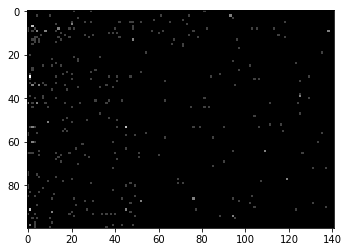

In [5]:
plt.imshow(X[:100].toarray(), cmap="gray")

In [7]:
#Get a random training and testing set
X_train, X_test, y_train2, y_test2 = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

#y is a vector, it has to be a matrix, this loop creates a matrix size y.shape[0]x2
y2 = np.zeros((y.shape[0], 2))
for i in range(y.shape[0]):
    y2[i, 0] = y[i]
    if y[i] == 0:
        y2[i, 1] = 1
    else:
        y2[i, 1] = 0
y = y2

In [9]:
#modify the type from np.float64 (default type) to np.float32
X = X.A.astype(np.float32)
X_train = X_train.A.astype(np.float32)
y_train2 = y_train2.astype(np.int32)
X_test = X_test.A.astype(np.float32)
y_test2 = y_test2.astype(np.int32)

In [10]:
a = 0
b = 0
y_train = np.zeros((y_train2.shape[0], 2))
for i in range(y_train2.shape[0]):
    y_train[i, 0] = y_train2[i]
    if y_train2[i] == 0:
        a += 1
        y_train[i, 1] = 1
    else:
        y_train[i, 1] = 0
        b += 1
        
y_test = np.zeros((y_test2.shape[0], 2))
for i in range(y_test2.shape[0]):
    y_test[i, 0] = y_test2[i]
    if y_test2[i] == 0:
        a += 1 
        y_test[i, 1] = 1
    else:
        y_test[i, 1] = 0
        b += 1

747
4825
(3733, 141)
(3733, 2)
(1839, 141)
(1839, 2)


In [12]:
# Create model (this should work without any change)
def neural_net(x, num_input, weights, biases):
    x_matrix = tf.reshape(x, [-1, num_input])
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x_matrix, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.nn.softmax(tf.matmul(layer_2, weights['out']) + biases['out'])
    return out_layer

In [13]:
# Construct model (this should work without any change)
def create_model_train_test(X_train, y_train, X_test, y_test, neurons, lr, bz):
    
    # Parameters for the classifier
    learning_rate = lr
    batch_size = bz #the classifier will take blocks of 128 to run the classifier
    display_step = 5
    num_steps = int(X_train.shape[0]/batch_size) # 58 = ceil(7406/128) = ceil(57.85)


    # Network Parameters
    n_hidden_1 = neurons # 1st layer number of neurons
    n_hidden_2 = neurons # 2nd layer number of neurons
    num_input = X_train.shape[1] # number of features
    num_classes = y_train.shape[1] # total amount of classes

    # tf Graph input
    X = tf.placeholder(tf.float32, [None], name="input")
    Y = tf.placeholder(tf.int32, [None, num_classes], name="output")
    
    # Store layers weight & bias (this should work without any change)
    weights = {
        'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([num_classes]))
    }
    
    logits = neural_net(X, num_input, weights, biases)
    sofmax_out = tf.nn.softmax(logits)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for i in range(1, num_steps+1):
            batch_x = X_train[(i-1)*batch_size: (i-1)*batch_size + batch_size - 1] #take a block of 128 instances
            batch_y = y_train[(i-1)*batch_size: (i-1)*batch_size + batch_size - 1] #take a block of 128 instances
            batch_x = batch_x.ravel()
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})


        y_out = sess.run(sofmax_out, feed_dict={X: X_test.ravel()})
        acc =  np.mean((y_test - y_out.round()) == 0)
        mcc = matthews_corrcoef(y_test[:,0], y_out.round()[:,0])
        print('with neurons', neurons, ' bz', bz, ' lr', lr,  \
              ' acc = ',acc, ' mcc = ', mcc)


        #this variables are used for the binary model, catch the current state for every weight and every bias
        W1 = weights['h1'].eval(sess)
        B1 = biases['b1'].eval(sess)
        W2 = weights['h2'].eval(sess)
        B2 = biases['b2'].eval(sess)
        W_OUT = weights['out'].eval(sess)
        B_OUT = biases['out'].eval(sess)

        sess.close()
        del sess
    
    return W1, B1, W2, B2, W_OUT, B_OUT, mcc

In [14]:
print(type(X))
neurons = [64,128,192,256,320,384,448]
for neuron in neurons:
    print(neuron)
print(type(enumerate(neurons)))

<class 'numpy.ndarray'>
64
128
192
256
320
384
448
<class 'enumerate'>


In [15]:
#Test the model with different nomber of neurons to find the most optimal value
#
t1 = time()
k = 0
mcc = -2
mccs = np.zeros(9*10).reshape(9,10)
neurons = [32,64,128,256]
bz = [1,4,8,16,32,64,128]
split = 10
mccs = np.zeros(len(neurons)*split).reshape(len(neurons),split)
for i, neuron in enumerate(neurons):
    print('------bz ', neuron, '--------')
    kf = KFold(n_splits=split, shuffle=True, random_state=random.randint(1,100))
    k = 0
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        #print((y_train.shape))
        mcc_old = mcc
        W1, B1, W2, B2, W_OUT, B_OUT, mcc = create_model_train_test(X_train, y_train, X_test, y_test, neuron, 0.01, 16)
        W1_old, B1_old, W2_old, B2_old, W_OUT_old, B_OUT_old = W1, B1, W2, B2, W_OUT, B_OUT
        mccs[i][k] = mcc
        k += 1
        if(mcc != -2):
            if(mcc < mcc_old):
                mcc = mcc_old
                W1, B1, W2, B2, W_OUT, B_OUT = W1_old, B1_old, W2_old, B2_old, W_OUT_old, B_OUT_old
    
    print('mean mcc ',mccs.mean(axis=1)[i])
            
print('best mcc ', mcc)
print('where the mcc is better in mccs ',np.argmax(mccs.mean(axis=1)))
print('best value in mccs ',mccs.mean(axis=1)[np.argmax(mccs.mean(axis=1))])
print('highest neurons', neurons[np.argmax(mccs.mean(axis=1))])
print(time() - t1)

------bz  32 --------
with neurons 32  bz 16  lr 0.01  acc =  0.915770609319  mcc =  0.492955373195
with neurons 32  bz 16  lr 0.01  acc =  0.931899641577  mcc =  0.685782875433
with neurons 32  bz 16  lr 0.01  acc =  0.915619389587  mcc =  0.599475104903
with neurons 32  bz 16  lr 0.01  acc =  0.924596050269  mcc =  0.621225456338
with neurons 32  bz 16  lr 0.01  acc =  0.913824057451  mcc =  0.557129928708
with neurons 32  bz 16  lr 0.01  acc =  0.901256732496  mcc =  0.627558565165
with neurons 32  bz 16  lr 0.01  acc =  0.877917414722  mcc =  0.245593781224
with neurons 32  bz 16  lr 0.01  acc =  0.874326750449  mcc =  0.354089879856
with neurons 32  bz 16  lr 0.01  acc =  0.933572710952  mcc =  0.654760351104
with neurons 32  bz 16  lr 0.01  acc =  0.858168761221  mcc =  0.177111036072
mean mcc  0.5015682352
------bz  64 --------
with neurons 64  bz 16  lr 0.01  acc =  0.883512544803  mcc =  0.164672961221
with neurons 64  bz 16  lr 0.01  acc =  0.910394265233  mcc =  0.6032200842

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


with neurons 64  bz 16  lr 0.01  acc =  0.874326750449  mcc =  0.0
with neurons 64  bz 16  lr 0.01  acc =  0.858168761221  mcc =  0.0
with neurons 64  bz 16  lr 0.01  acc =  0.883303411131  mcc =  0.354257880786
with neurons 64  bz 16  lr 0.01  acc =  0.906642728905  mcc =  0.48915524077
with neurons 64  bz 16  lr 0.01  acc =  0.903052064632  mcc =  0.541464179055
with neurons 64  bz 16  lr 0.01  acc =  0.879712746858  mcc =  0.220759505385
with neurons 64  bz 16  lr 0.01  acc =  0.856373429084  mcc =  0.199023173642
with neurons 64  bz 16  lr 0.01  acc =  0.876122082585  mcc =  0.218992217261
mean mcc  0.279154524236
------bz  128 --------
with neurons 128  bz 16  lr 0.01  acc =  0.874551971326  mcc =  0.11097054237
with neurons 128  bz 16  lr 0.01  acc =  0.874551971326  mcc =  0.341065996987
with neurons 128  bz 16  lr 0.01  acc =  0.797127468582  mcc =  0.300663584202
with neurons 128  bz 16  lr 0.01  acc =  0.865350089767  mcc =  0.106691137702
with neurons 128  bz 16  lr 0.01  ac

In [18]:

#W1, B1, W2, B2, W_OUT, B_OUT, mcc = create_model_train_test(X_train, y_train, X_test, y_test, 296, 0.001, 3)

mcc = -2
mcc_old = mcc
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random.randint(1,100))
    mcc_old = mcc
    W1, B1, W2, B2, W_OUT, B_OUT, mcc = create_model_train_test(X_train, y_train, X_test, y_test, 8, 0.01, 4)
    W1_old, B1_old, W2_old, B2_old, W_OUT_old, B_OUT_old = W1, B1, W2, B2, W_OUT, B_OUT
    if(mcc != -2):
        if(mcc < mcc_old):
            mcc = mcc_old
            W1, B1, W2, B2, W_OUT, B_OUT = W1_old, B1_old, W2_old, B2_old, W_OUT_old, B_OUT_old

            
print('best mcc ', mcc)



with neurons 8  bz 4  lr 0.01  acc =  0.927678085916  mcc =  0.665490090076
with neurons 8  bz 4  lr 0.01  acc =  0.941272430669  mcc =  0.709281989101
with neurons 8  bz 4  lr 0.01  acc =  0.932572050027  mcc =  0.666444315258
with neurons 8  bz 4  lr 0.01  acc =  0.925502990756  mcc =  0.648714118212
with neurons 8  bz 4  lr 0.01  acc =  0.927134312126  mcc =  0.639895973733
with neurons 8  bz 4  lr 0.01  acc =  0.908646003263  mcc =  0.572176337908
with neurons 8  bz 4  lr 0.01  acc =  0.933659597607  mcc =  0.686576598324
with neurons 8  bz 4  lr 0.01  acc =  0.920609026645  mcc =  0.621277980041
with neurons 8  bz 4  lr 0.01  acc =  0.935834692768  mcc =  0.702228873111
with neurons 8  bz 4  lr 0.01  acc =  0.917890157694  mcc =  0.585025897371
best mcc  0.709281989101


In [17]:
#create the model
DIR = '/sms_model/' # path where the model will be create it
g = tf.Graph()
with g.as_default():
    
    # this steps are the same as the function neural_net() but instead of random values will 
    # take the value in every weight and every bias at the end of the classifier
    
    #create the input parameter which is a vector
    x_2 = tf.placeholder(tf.float32, shape=[None], name="input")
    
    #reshape the vector into a matrix, this has to be done because the the op matmul
    #requires two matrix's
    x_22 = tf.reshape(x_2, [-1, 141])
    
    #create each weight and each biase with the final value
    W1_C = tf.constant(W1, name="W1")
    B1_C = tf.constant(B1, name="B1")
    W2_C = tf.constant(W2, name="W2")
    B2_C = tf.constant(B2, name="B2")
    W_OUT_C = tf.constant(W_OUT, name="W_OUT")
    B_OUT_C = tf.constant(B_OUT, name="B_OUT")
    
    
    # the two layers as used in neural_net()
    layer_1 = tf.add(tf.matmul(x_22, W1_C, name="matmul_x_22_w1_c"), B1_C, name="add_matmul1_b1_c")
    layer_2 = tf.add(tf.matmul(layer_1, W2_C, name="matmul_l_1_w1_c"), B2_C, name="add_matmul2_b2_c")
    #the output value of the classifier with the name output
    OUTPUT = tf.nn.softmax(tf.matmul(layer_2, W_OUT, name="matmul_l_2_wout_c") + B_OUT, name="output")
    

    # skipped dropout for exported graph as there is no need for already calculated weights
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    graph_def = g.as_graph_def()
    
    #create the model model_graph.pb
    tf.train.write_graph(graph_def, DIR, 'sms_model_opt5.pb', as_text=False) #check accuracy 0.910277 in 1

    
    # Test trained model
    y_train2 = tf.placeholder(tf.float32, [None, 2])
    correct_prediction = tf.equal(tf.argmax(OUTPUT, 1), tf.argmax(y_train2, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #print("check accuracy %g" % accuracy.eval({x_2: X_test.ravel(), y_train: y_test}, sess))